# [GCViT: Global Context Vision Transformer](https://arxiv.org/pdf/2206.09959v1.pdf)


<div align=center><img src="https://raw.githubusercontent.com/awsaf49/gcvit-tf/main/image/lvg_arch.PNG" width=800></div>

<br>
<div align=center><p>
<a target="_blank" href="https://huggingface.co/spaces/awsaf49/gcvit-tf"><img src="https://img.shields.io/badge/🤗%20Hugging%20Face-Spaces-yellow.svg"></a>
</p></div>
</br>

* Code: https://github.com/awsaf49/gcvit-tf
 
    
    

In [1]:
!pip install -qU gcvit # stable
# !pip install -qU git+https://github.com/awsaf49/gcvit-tf # latest but unstable

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
import gcvit

print("Tensorflow version: " + tf.__version__)
print("GCViT version: ", gcvit.__version__)

2022-07-21 04:32:07.430533: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-07-21 04:32:07.430696: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Tensorflow version: 2.4.1
GCViT version:  1.0.6


# Detect my accelerator

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    tpu = None
    strategy = tf.distribute.get_strategy()

2022-07-21 04:32:12.621946: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-21 04:32:12.624577: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-07-21 04:32:12.624616: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-21 04:32:12.624644: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (d102c8e446b8): /proc/driver/nvidia/version does not exist
2022-07-21 04:32:12.627292: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

# Get my data path

In [4]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path() # you can list the bucket with "!gsutil ls $GCS_DS_PATH"

# Set some parameters

In [5]:
DIM = 224
IMAGE_SIZE = [DIM, DIM] # at this size, a GPU will run out of memory. Use the TPU
EPOCHS = 20
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

NUM_TRAINING_IMAGES = 12753
NUM_TEST_IMAGES = 7382
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
AUTO = tf.data.experimental.AUTOTUNE

# Load my data

This data is loaded from Kaggle and automatically sharded to maximize parallelization.

In [6]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset():
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + F'/tfrecords-jpeg-{DIM}x{DIM}/train/*.tfrec'), labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset():
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + F'/tfrecords-jpeg-{DIM}x{DIM}/val/*.tfrec'), labeled=True, ordered=False)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + f'/tfrecords-jpeg-{DIM}x{DIM}/test/*.tfrec'), labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()

2022-07-21 04:32:19.810416: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-07-21 04:32:20.059660: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


# Learning Rate Scheduler

Learning rate schedule: 1e-05 to 0.0004 to 1.56e-05


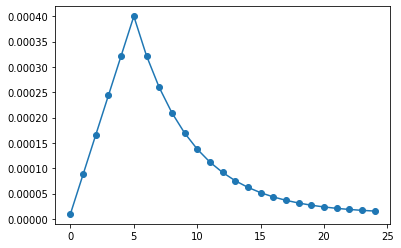

In [7]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)

rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Build a model

In [8]:
from gcvit import GCViTTiny

with strategy.scope():    
    model = GCViTTiny(input_shape=(*IMAGE_SIZE,3), pretrain=True)
    model.reset_classifier(num_classes=104, head_act='softmax')
        
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

model.build_graph().summary()

113500160/113494248 [==============================] - 2s 0us/step
Model: "gcvit_tiny"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
patch_embed (PatchEmbed)     (None, 56, 56, 64)        45632     
_________________________________________________________________
pos_drop (Dropout)           (None, 56, 56, 64)        0         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, 56, 56, 64)        0         
_________________________________________________________________
levels/0 (GCViTLayer)        (None, 28, 28, 128)       223030    
_________________________________________________________________
levels/1 (GCViTLayer)        (None, 14, 14, 256)       1004048   
_______________________________________________________

# Save Checkpoint

In [9]:
ckpt_path = 'model.h5'
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_path,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    verbose=1)

# Training

In [10]:
history = model.fit(training_dataset, 
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=EPOCHS, 
          validation_data=validation_dataset,
          callbacks=[lr_callback, ckpt_callback])

Epoch 1/20
49/49 [==============================] - 249s 1s/step - loss: 4.6400 - sparse_categorical_accuracy: 0.0370 - val_loss: 3.9725 - val_sparse_categorical_accuracy: 0.1517


2022-07-21 04:36:59.475216: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 53080, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1658378219.471797957","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 53080, Output num: 0","grpc_status":3}



Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.15167, saving model to model.h5
Epoch 2/20
49/49 [==============================] - 22s 450ms/step - loss: 2.9346 - sparse_categorical_accuracy: 0.3693 - val_loss: 0.6651 - val_sparse_categorical_accuracy: 0.8378

Epoch 00002: val_sparse_categorical_accuracy improved from 0.15167 to 0.83782, saving model to model.h5
Epoch 3/20
49/49 [==============================] - 22s 451ms/step - loss: 0.7267 - sparse_categorical_accuracy: 0.8085 - val_loss: 0.3655 - val_sparse_categorical_accuracy: 0.9060

Epoch 00003: val_sparse_categorical_accuracy improved from 0.83782 to 0.90598, saving model to model.h5
Epoch 4/20
49/49 [==============================] - 22s 453ms/step - loss: 0.3058 - sparse_categorical_accuracy: 0.9187 - val_loss: 0.3103 - val_sparse_categorical_accuracy: 0.9248

Epoch 00004: val_sparse_categorical_accuracy improved from 0.90598 to 0.92484, saving model to model.h5
Epoch 5/20
49/49 [======================

# History

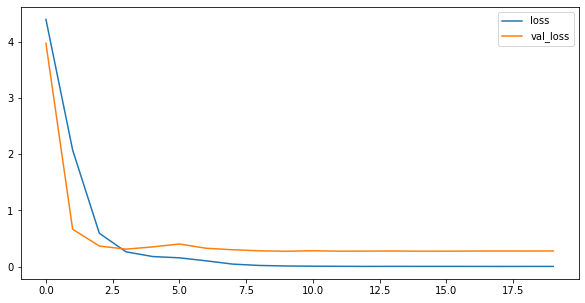

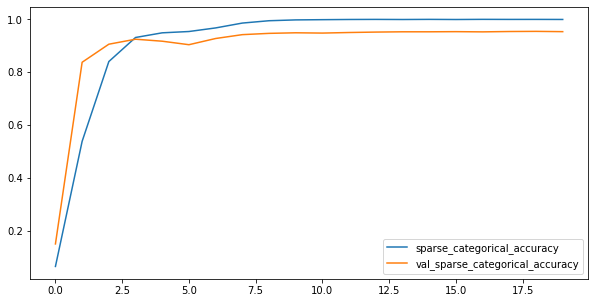

In [11]:
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 5)
data = pd.DataFrame(history.history)
metrics = ['loss', 'sparse_categorical_accuracy']
for metric in metrics:
    data[[f'{metric}',f'val_{metric}']].plot()

# Load Best Model

In [12]:
# load best model
model.load_weights(ckpt_path)

# Compute your predictions on the test set!

This will create a file that can be submitted to the competition.

In [13]:
# infer
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds, verbose=1)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')

2022-07-21 04:44:35.095336: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Computing predictions...
29/29 [==============================] - 56s 820ms/step
[ 67  28  83 ...  86 102  62]
Generating submission.csv file...


2022-07-21 04:45:31.675574: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 111465, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1658378731.675456045","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 111465, Output num: 0","grpc_status":3}
